## Link deploy
Demo cho ch∆∞∆°ng tr√¨nh: [Link](https://share.streamlit.io/tgthuan/demo-fakenewsdetection-ml/app.py)

<h1 align="center">
B·∫£ng ph√¢n c√¥ng c√¥ng vi·ªác
</h1>

|MSSV| H·ªç t√™n| C√¥ng vi·ªác|
|---|---|---|
|19120212| V≈© C√¥ng Duy| M√¥ h√¨nh h√≥a|
|19120297| ƒêo√†n Vi·ªát Nam| Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu v√† bonus point|
|19120328| V√µ Tr·ªçng Ph√∫| Kh√°m ph√° d·ªØ li·ªáu|
|19120389| T√¥ Gia Thu·∫≠n| M√¥ h√¨nh h√≥a, Deploy m√¥ h√¨nh|
|19120602| H·ªì H·ªØu Ng·ªçc| Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu|

<hr>


In [1]:
!pip install vncorenlp

In [2]:
!pip install wordcloud

In [3]:
!pip install nltk

In [4]:
!pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
import vncorenlp
from vncorenlp import VnCoreNLP
import re
import seaborn as sns
import copy
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import wordcloud
from wordcloud import WordCloud
import nltk
from nltk import tokenize
import os
import tensorflow as tf
# tf.get_logger().setLevel('INFO')


2022-01-09 13:39:52.960256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 13:39:52.960270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## ƒê·ªçc data, stopwords, th∆∞ vi·ªán java

In [6]:
data=pd.read_csv("vn_news_223_tdlfr.csv")
f = open('resources/stopwords.txt', 'r', encoding='UTF-8')
stopwords = f.read().split('\n')
annotator = VnCoreNLP("resources/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')
data.head()

text               domain  \
0  Th·ªß t∆∞·ªõng Abe c√∫i ƒë·∫ßu xin l·ªói v√¨ h√†nh ƒë·ªông phi...         binhluan.biz   
1  Th·ªß t∆∞·ªõng Nh·∫≠t c√∫i ƒë·∫ßu xin l·ªói v√¨ tinh th·∫ßn ph...         www.ipick.vn   
2  Cho√°ng! C∆° tr∆∞·ªüng ƒëeo khƒÉn qu√†ng qu·∫©y banh n√≥c...       tintucqpvn.net   
3  Ch∆∞a bao gi·ªù nh·∫°c Kpop l·∫°i d·ªÖ h√°t ƒë·∫øn th·∫ø!!!\n...       tintucqpvn.net   
4  ƒê·∫°i h·ªçc Hutech s·∫Ω √°p d·ª•ng c·∫£i c√°ch "Ti·∫øq Vi·ªát"...  www.gioitreviet.net   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu (Data preprocessing)
## 1. X·ª≠ l√Ω noise
C√°c noise trong vƒÉn b·∫£n bao g·ªìm c√°c link, d·∫•u xu·ªëng d√≤ng, c√°c k√≠ t·ª± ƒë·∫∑c bi·ªát, vi·∫øt hoa s·∫Ω ƒë∆∞·ª£c x·ª≠ l√Ω

In [7]:
def NoiseDefuse(s):
    result = copy.copy(s)
    result = result.str.lower()
    result = result.apply(lambda x: re.sub(r'http\S+', '', x))
    result = result.apply(lambda x: x.replace('\n',' '))
    result = result.apply(lambda x: re.sub('[^a√†·∫£√£√°·∫°ƒÉ·∫±·∫≥·∫µ·∫Ø·∫∑√¢·∫ß·∫©·∫´·∫•·∫≠ b c dƒëe√®·∫ª·∫Ω√©·∫π√™·ªÅ·ªÉ·ªÖ·∫ø·ªá f g hi√¨·ªâƒ©√≠·ªãjklmno√≤·ªè√µ√≥·ªç√¥·ªì·ªï·ªó·ªë·ªô∆°·ªù·ªü·ª°·ªõ·ª£pqrstu √π·ªß≈©√∫·ª•∆∞·ª´·ª≠·ªØ·ª©·ª±vwxy·ª≥·ª∑·ªπ√Ω·ªµz +[0-9]+', '', x))
    return result

## 2. TokenNize

In [8]:
#Gi·∫£m chi·ªÅu d·ªØ li·ªáu
def reduce_dim(x):
    return x[0]

#T√°ch t·ª´
def TokenNize(s):
    return s.apply(annotator.tokenize).apply(reduce_dim)


## 3.Normalize

In [9]:
#H√†m chuy·ªÉn c√°c t·ª´ vi·∫øt t·∫Øt v·ªÅ d·∫°ng ƒë·∫ßy ƒë·ªß
def normalized1(x):
    contractions={
        ' cƒëv': ' c·ªï ƒë·ªông vi√™n',
        ' thcs': ' trung h·ªçc c∆° s·ªü',
        ' pgs': ' ph√≥ gi√°o s∆∞ ',
        ' gs': ' gi√°o s∆∞ ',
        ' ts': ' ti·∫øn sƒ© ',
        ' gd  ƒët': ' gi√°o d·ª•c - ƒë√†o t·∫°o',
        ' gd ƒët': ' gi√°o d·ª•c - ƒë√†o t·∫°o',
        ' gdƒët': ' gi√°o d·ª•c - ƒë√†o t·∫°o',
        ' hlv': ' hu·∫•n luy·ªán vi√™n',
        ' tp': ' th√†nh ph·ªë ',
        ' hcm': ' H·ªì Ch√≠ Minh ',
        ' ƒët': ' ƒë·ªôi tuy·ªÉn ',
        ' gd': ' gi√°o d·ª•c '
    }
    for k,v in contractions.items():
        x=x.replace(k,v)
    return x
def normalized(s):
    return s.apply(normalized1)

## 4. Remove stopword

In [10]:
#H√†m lo·∫°i b·ªè c√°c stopword
def remove_stopword(list_word):
    clean_list = []
    for i in range(len(list_word)):
        temp=list_word[i].replace('_',' ')
        if temp not in stopwords :
            clean_list.append(list_word[i])
    return clean_list


## 5. T·ªïng h·ª£p

In [11]:
def Preprocess(s):
    a= TokenNize(normalized(NoiseDefuse(s)))
    a=a.apply(remove_stopword)
    return a
data['clean_text']= Preprocess(data['text'])
data

text               domain  \
0    Th·ªß t∆∞·ªõng Abe c√∫i ƒë·∫ßu xin l·ªói v√¨ h√†nh ƒë·ªông phi...         binhluan.biz   
1    Th·ªß t∆∞·ªõng Nh·∫≠t c√∫i ƒë·∫ßu xin l·ªói v√¨ tinh th·∫ßn ph...         www.ipick.vn   
2    Cho√°ng! C∆° tr∆∞·ªüng ƒëeo khƒÉn qu√†ng qu·∫©y banh n√≥c...       tintucqpvn.net   
3    Ch∆∞a bao gi·ªù nh·∫°c Kpop l·∫°i d·ªÖ h√°t ƒë·∫øn th·∫ø!!!\n...       tintucqpvn.net   
4    ƒê·∫°i h·ªçc Hutech s·∫Ω √°p d·ª•ng c·∫£i c√°ch "Ti·∫øq Vi·ªát"...  www.gioitreviet.net   
..                                                 ...                  ...   
218  ‚ÄúSi√™u m√°y bay‚Äù A350 s·∫Ω ch·ªü CƒêV Vi·ªát Nam ƒëi Mal...        dantri.com.vn   
219  Th∆∞·ªüng 20.000 USD cho ƒë·ªôi tuy·ªÉn c·ªù vua Vi·ªát Na...        dantri.com.vn   
220  Tr∆∞·ªùng S∆°n gi√†nh HCV t·∫°i gi·∫£i c·ªù vua ƒë·ªìng ƒë·ªôi ...        dantri.com.vn   
221  Chuy·ªán v·ªÅ ch√†ng sinh vi√™n Lu·∫≠t - Ki·ªán t∆∞·ªõng L√™...        dantri.com.vn   
222  Ti·ªÅn ƒë·∫°o Malaysia: ‚ÄúT√¥i ƒë√£ c√≥ c√°ch v∆∞·ª£t qua h√†...        dantri.com.vn   

     label                                         clean_text  
0        1  [th·ªß_t∆∞·ªõng, abe, c√∫i, ƒë·∫ßu, xin_l·ªói, h√†nh_ƒë·ªông,...  
1        1  [th·ªß_t∆∞·ªõng, nh·∫≠t, c√∫i, ƒë·∫ßu, xin_l·ªói, tinh_th·∫ßn...  
2        1  [cho√°ng, c∆°_tr∆∞·ªüng, ƒëeo, khƒÉn_qu√†ng, qu·∫©y, ban...  
3        1  [nh·∫°c, kpop, h√°t, gi√°o_s∆∞, nguy·ªÖn_l√¢n, d≈©ng, t...  
4        1  [ƒë·∫°i_h·ªçc, hutech, √°p_d·ª•ng, c·∫£i_c√°ch, ti·∫øq, vi·ªá...  
..     ...                                                ...  
218      0  [si√™u, m√°y_bay, a350, ch·ªü, c·ªï_ƒë·ªông_vi√™n, vi·ªát_...  
219      0  [th∆∞·ªüng, 20000, usd, ƒë·ªôi_tuy·ªÉn, c·ªù_vua, vi·ªát_n...  
220      0  [tr∆∞·ªùng_s∆°n, gi√†nh, hcv, gi·∫£i, c·ªù_vua, ƒë·ªìng_ƒë·ªô...  
221      0  [ch√†ng, sinh_vi√™n, lu·∫≠t, ki·ªán_t∆∞·ªõng, l√™_tu·∫•n, ...  
222      0  [ti·ªÅn_ƒë·∫°o, malaysia, h√†ng, th·ªß, ƒë·ªôi_tuy·ªÉn, vi·ªá...  

[223 rows x 4 columns]

# Kh√°m ph√° d·ªØ li·ªáu

## D·ªØ li·ªáu c√≥ b·ªã thi·∫øu kh√¥ng ? C√≥ c·ªôt n√†o sai ki·ªÉu d·ªØ li·ªáu kh√¥ng ? 

In [12]:
data.isnull().values.any()
#data.dropna()

False

V·∫≠y l√† d·ªØ li·ªáu kh√¥ng c√≥ gi√° tr·ªã thi·∫øu

In [13]:
data.dtypes

text          object
domain        object
label          int64
clean_text    object
dtype: object

C√°c c·ªôt d·ªØ li·ªáu ƒë·ªÅu c√≥ gi√° tr·ªã ƒë√∫ng

## C√°c text c√≥ k√≠ch th∆∞·ªõc nh∆∞ th·∫ø n√†o ?

### M√¥ t·∫£ k√≠ch th∆∞·ªõc

In [14]:
copy_data = data
copy_data['text_length'] = [len(a) for a in copy_data['text']]
copy_data['text_length'].describe()

count      223.000000
mean      2539.771300
std       1780.532008
min        309.000000
25%       1286.000000
50%       2009.000000
75%       3300.500000
max      10019.000000
Name: text_length, dtype: float64

### K√≠ch th∆∞·ªõc trung b√¨nh c·ªßa m·ªói text

In [15]:
copy_data['text_length'].mean()

2539.7713004484303

## M·ªói mi·ªÅn b√°o c√≥ bao nhi√™u b√†i vi·∫øt ?

### Ta c√≥ th·ªÉ in ra s·ªë l∆∞·ª£ng text c·ªßa t·ª´ng domain

In [16]:
domain_count = data.groupby(['domain'])['text'].count()
domain_count = domain_count.sort_values(ascending=False,)
domain_count

domain
vnexpress.net              73
tinvn.info                 68
dantri.com.vn              14
thethao.tuoitre.vn         10
thoibao.today               6
news.zing.vn                6
tuoitre.vn                  5
tintucqpvn.net              5
thanhnien.vn                5
kinhdoanh.vnexpress.net     3
phapluat.news               3
thegioitre.vn               2
giaitri.vnexpress.net       2
giadinhtiepthi.com          2
doisong.vnexpress.net       2
thoibao.de                  2
www.ipick.vn                2
www.gioitreviet.net         1
autoxe.net                  1
sohoa.vnexpress.net         1
suckhoe.vnexpress.net       1
sorry.vn                    1
baoangiang.com.vn           1
laodong.vn                  1
https://news.zing.vn        1
haiduong.tintuc.vn          1
dulich.vnexpress.net        1
binhluan.biz                1
baonuocmy.com               1
www.vietgiaitri.com/        1
Name: text, dtype: int64

### Mi·ªÅn b√°o c√≥ nhi·ªÅu b√†i nh·∫•t

In [17]:
print("Mi·ªÅn b√°o c√≥ nhi·ªÅu b√†i nh·∫•t:")
domain_count.idxmax()

Mi·ªÅn b√°o c√≥ nhi·ªÅu b√†i nh·∫•t:


'vnexpress.net'

### Hmm, s·ª≠ d·ª•ng bi·ªÉu ƒë·ªì bar chart ƒë·ªÉ nh√¨n t·ªïng qu√°t h∆°n

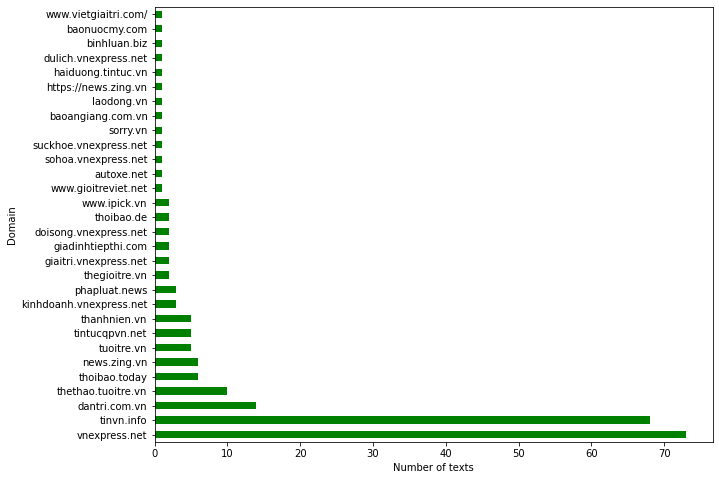

In [18]:
domain_count.plot(kind="barh", color = "green", figsize = (10,8))
plt.xlabel("Number of texts")
plt.ylabel("Domain")
plt.show()

## Tin gi·∫£ v√† tin th·∫≠t

### Ta c√≥ th·ªÉ in ra s·ªë l∆∞·ª£ng tin gi·∫£ ( ·ª©ng v·ªõi 1) v√† tin th·∫≠t ( ·ª©ng v·ªõi 0)

In [19]:
label_count = data.groupby(['label'])['text'].count()
label_count

label
0    123
1    100
Name: text, dtype: int64

### M·ªôt v√†i bi·ªÉu ƒë·ªì 

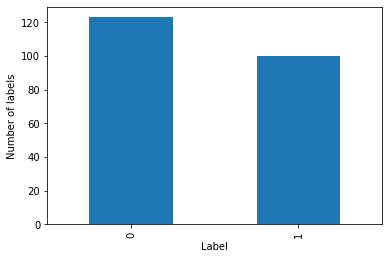

In [20]:
label_count.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Number of labels")
plt.show()

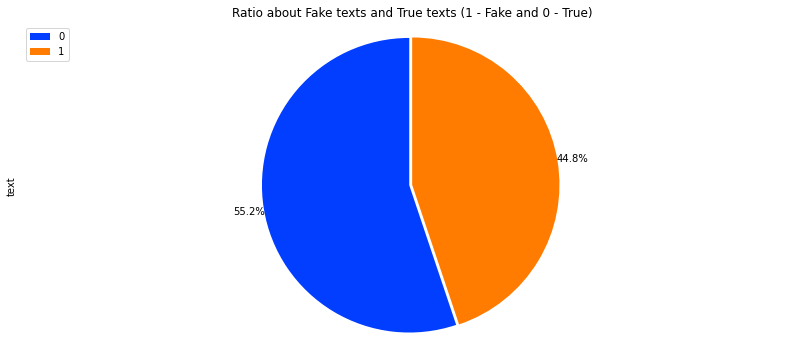

In [21]:
explode_list=[0,0.02]
label_count.plot(kind='pie',figsize=(14,6),autopct="%1.1f%%", startangle=90, labels=None, pctdistance=1.1
                            , explode=explode_list, colors = sns.color_palette('bright')[0:2])
plt.title("Ratio about Fake texts and True texts (1 - Fake and 0 - True)")
plt.axis('equal')
plt.legend(labels = label_count.index, loc='upper left');

Tuy c√≥ v·∫ª ch√™nh l·ªách kh√¥ng nhi·ªÅu nh∆∞ng tin th·∫≠t v·∫´n c√≥ s·ªë l∆∞·ª£ng l·ªõn h∆°n tin gi·∫£.

M·∫≠t ƒë·ªô c·ªßa tin gi·∫£ v√† tin th·∫≠t kh√° ƒë·ªÅu nhau.

## Nh·ªØng t·ª´ kh√≥a xu·∫•t hi·ªán nhi·ªÅu nh·∫•t 

### ƒê·ªëi v·ªõi c√°c tin th·∫≠t (label = 0) th√¨ nh·ªØng t·ª´ kh√≥a n√†o xu·∫•t hi·ªán nhi·ªÅu nh·∫•t trong c√°c b√†i vi·∫øt ?

M√¨nh s·∫Ω l·∫•y ra danh s√°ch 20 t·ª´ ƒë∆∞·ª£c d√πng nhi·ªÅu nh·∫•t trong b·ªô tin th·∫≠t

In [22]:
true_data = data[data["label"] == 0]
true_token_space = tokenize.WhitespaceTokenizer()
true_data_text = true_data['clean_text'].explode()
true_data_text = ' '.join(true_data_text)
true_token_phrase = true_token_space.tokenize(true_data_text)
true_count = nltk.FreqDist(true_token_phrase)
true_data_df = pd.DataFrame({"Word": list(true_count.keys()), "Number of words": list(true_count.values())})
true_data_df = true_data_df.nlargest(columns = "Number of words", n = 20)

In [23]:
true_data_df

Word  Number of words
217            ƒëi              270
294     th√†nh_ph·ªë              214
39             xe              188
58            ·∫£nh              181
30          ƒë∆∞·ªùng              175
51            hai              144
295   H·ªì_Ch√≠_Minh              137
148      vi·ªát_nam              115
271           nam              106
101             2               98
252          h√†ng               89
141       c√¥ng_an               88
1257      m√°y_bay               86
293           bay               81
288          ƒë·ªìng               80
1316     c·∫£nh_s√°t               79
37             v·ª•               77
1258       chuy·∫øn               77
1041          khu               75
155      ƒëi·ªÅu_tra               74

D√πng bar chart ƒë·ªÉ nh√¨n r√µ n√†o

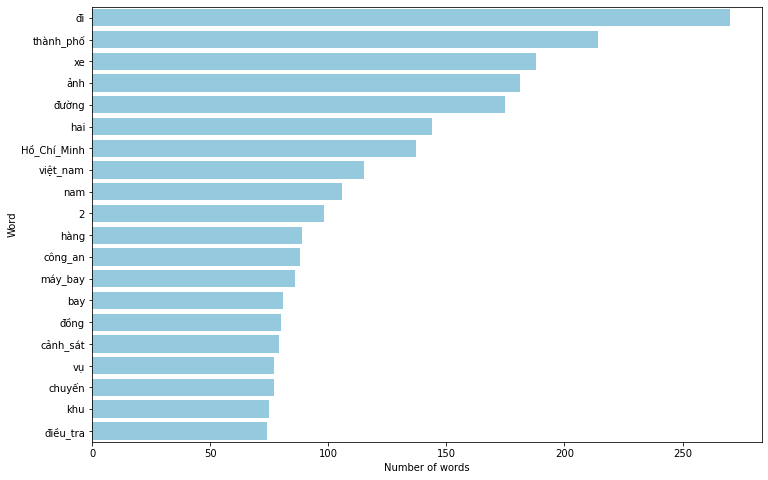

In [24]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = true_data_df, x = "Number of words", y = "Word", color = 'skyblue')
plt.show()

T·ª´ "ƒëi" ƒë∆∞·ª£c d√πng nhi·ªÅu nh·∫•t v·ªõi h∆°n 250 l·∫ßn (c·ª• th·ªÉ l√† 270)

### ƒê·ªëi v·ªõi c√°c tin gi·∫£ (label = 1) th√¨ nh·ªØng t·ª´ kh√≥a n√†o xu·∫•t hi·ªán nhi·ªÅu nh·∫•t trong c√°c b√†i vi·∫øt ?

T∆∞∆°ng t·ª±, M√¨nh s·∫Ω l·∫•y ra danh s√°ch 20 t·ª´ ƒë∆∞·ª£c d√πng nhi·ªÅu nh·∫•t trong b·ªô tin gi·∫£ v√† v·∫Ω bi·ªÉu ƒë·ªì t∆∞∆°ng ·ª©ng.

In [25]:
fake_data = data[data["label"] == 1]
fake_token_space = tokenize.WhitespaceTokenizer()
fake_data_text = fake_data['clean_text'].explode()
fake_data_text = ' '.join(fake_data_text)
fake_token_phrase = fake_token_space.tokenize(fake_data_text)
fake_count = nltk.FreqDist(fake_token_phrase)
fake_data_df = pd.DataFrame({"Word": list(fake_count.keys()), "Number of words": list(fake_count.values())})
fake_data_df = fake_data_df.nlargest(columns = "Number of words", n = 20)

In [26]:
fake_data_df

Word  Number of words
69          ƒëi              258
1796     ch·ªìng              147
648         m·∫π              130
882        g√°i              116
433        ·∫£nh              110
2230        v·ª£              104
89           1               95
2186       ƒë·ª©c               93
227       m·∫°ng               90
73       th·∫Øng               75
91           2               75
220      ti·∫øng               75
2000     tr·ª©ng               75
118        hai               74
717         b√©               72
1558       r·∫Øn               72
2191   ƒë√†n_√¥ng               72
3          ƒë·∫ßu               71
354   vi·ªát_nam               71
45    h√¨nh_·∫£nh               70

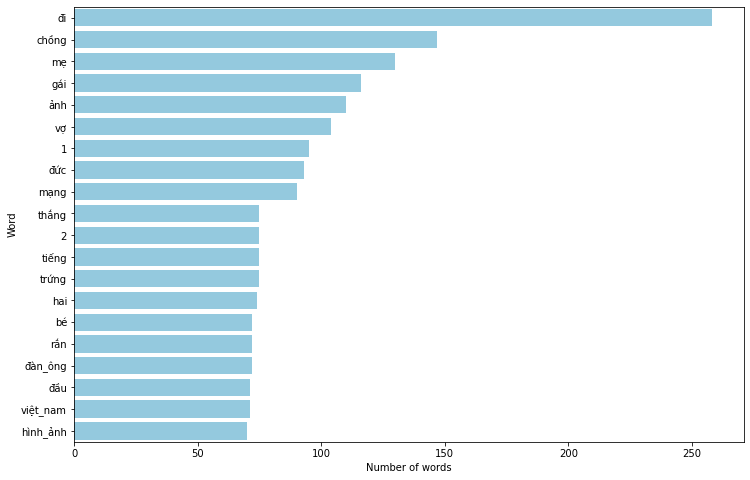

In [27]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = fake_data_df, x = "Number of words", y = "Word", color = 'skyblue')
plt.show()

T·ª´ "ƒëi" ƒë∆∞·ª£c d√πng nhi·ªÅu nh·∫•t v·ªõi h∆°n 250 l·∫ßn (c·ª• th·ªÉ l√† 258)

V·∫≠y l√† d√π cho tin gi·∫£ hay tin th·∫≠t th√¨ t·ª´ "ƒëi" v·∫´n ƒë∆∞·ª£c d√πng nhi·ªÅu nh·∫•t

## M√¥ h√¨nh ƒë√°m m√¢y d·ªØ li·ªáu

In [28]:
#fake news
fake_news = data[data['label']==1]
fake_news_text = fake_news['clean_text'].explode()
fake_news_text = ' '.join(fake_news_text)

wordcloud = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(fake_news_text)


plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Fake News')
plt.axis("off")
plt.show();

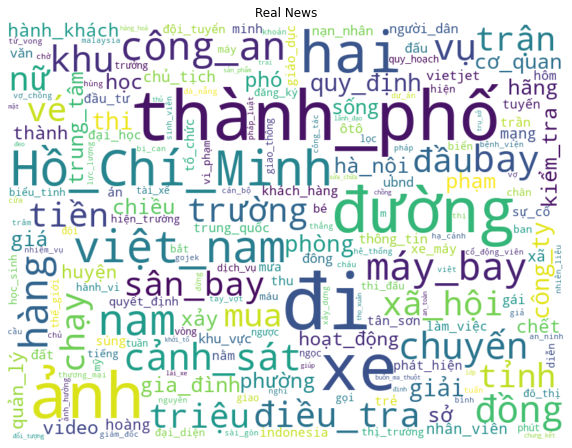

In [29]:
# real news
real_news = data[data['label']==0]
real_news_text = real_news['clean_text'].explode()
real_news_text = ' '.join(real_news_text)

wordcloud = WordCloud(width= 800, height= 600,
                          background_color='white',
                          max_font_size = 110,
                          collocations = False).generate(real_news_text)

plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Real News')
plt.axis("off")
plt.show();

# X√¢y d·ª±ng m√¥ h√¨nh
B·ªçn em s·∫Ω d√πng ph∆∞∆°ng th·ª©c CountVectorizer ƒë·ªÉ vector h√≥a vƒÉn b·∫£n. V√¨ v·∫≠y, b·ªçn em s·∫Ω g·ªôp token sau khi ƒë∆∞·ª£c l√†m s·∫°ch l·∫°i th√†nh 1 vƒÉn b·∫£n ƒë·ªÉ c√≥ th·ªÉ s·ª≠ d·ª•ng CountVectorizer().

## 1. Ti·ªÅn x·ª≠ l√Ω cho m√¥ h√¨nh

In [30]:
def fullPreprocess(s):
    return Preprocess(s).apply(lambda x:" ".join(x))

In [31]:
data['joined_clean_text'] = fullPreprocess(data['text'])
data.head()

text               domain  \
0  Th·ªß t∆∞·ªõng Abe c√∫i ƒë·∫ßu xin l·ªói v√¨ h√†nh ƒë·ªông phi...         binhluan.biz   
1  Th·ªß t∆∞·ªõng Nh·∫≠t c√∫i ƒë·∫ßu xin l·ªói v√¨ tinh th·∫ßn ph...         www.ipick.vn   
2  Cho√°ng! C∆° tr∆∞·ªüng ƒëeo khƒÉn qu√†ng qu·∫©y banh n√≥c...       tintucqpvn.net   
3  Ch∆∞a bao gi·ªù nh·∫°c Kpop l·∫°i d·ªÖ h√°t ƒë·∫øn th·∫ø!!!\n...       tintucqpvn.net   
4  ƒê·∫°i h·ªçc Hutech s·∫Ω √°p d·ª•ng c·∫£i c√°ch "Ti·∫øq Vi·ªát"...  www.gioitreviet.net   

   label                                         clean_text  text_length  \
0      1  [th·ªß_t∆∞·ªõng, abe, c√∫i, ƒë·∫ßu, xin_l·ªói, h√†nh_ƒë·ªông,...         2244   
1      1  [th·ªß_t∆∞·ªõng, nh·∫≠t, c√∫i, ƒë·∫ßu, xin_l·ªói, tinh_th·∫ßn...          884   
2      1  [cho√°ng, c∆°_tr∆∞·ªüng, ƒëeo, khƒÉn_qu√†ng, qu·∫©y, ban...         1232   
3      1  [nh·∫°c, kpop, h√°t, gi√°o_s∆∞, nguy·ªÖn_l√¢n, d≈©ng, t...         3093   
4      1  [ƒë·∫°i_h·ªçc, hutech, √°p_d·ª•ng, c·∫£i_c√°ch, ti·∫øq, vi·ªá...         8804   

                                   joined_clean_text  
0  th·ªß_t∆∞·ªõng abe c√∫i ƒë·∫ßu xin_l·ªói h√†nh_ƒë·ªông phi th...  
1  th·ªß_t∆∞·ªõng nh·∫≠t c√∫i ƒë·∫ßu xin_l·ªói tinh_th·∫ßn phi t...  
2  cho√°ng c∆°_tr∆∞·ªüng ƒëeo khƒÉn_qu√†ng qu·∫©y banh s√¢n_...  
3  nh·∫°c kpop h√°t gi√°o_s∆∞ nguy·ªÖn_l√¢n d≈©ng th√†nh_ƒë·∫°...  
4  ƒë·∫°i_h·ªçc hutech √°p_d·ª•ng c·∫£i_c√°ch ti·∫øq vi·ªát nƒÉm_...

## 2. Chia t·∫≠p test v√† validation
V√¨ ƒë√¢y l√† m√¥ h√¨nh d·ª± ƒëo√°n d·ª±a tr√™n text n√™n b·ªçn em s·∫Ω ch·ªâ x√©t c·ªôt `'joined_clean_text'` t·ª©c c·ªôt text sau khi qua nhi·ªÅu b∆∞·ªõc l√†m s·∫°ch v√† x·ª≠ l√Ω (b·ªè qua c·ªôt `domain`) l√†m t·∫≠p X v√† c·ªôt `'label'` l√†m t·∫≠p y.  
B·ªçn em s·∫Ω chia t·∫≠p train v√† validation ra theo t·ªâ l·ªá 7/3.

In [32]:
X_train, X_val,y_train,y_val = train_test_split(data['joined_clean_text'],data['label'],random_state=212,test_size=0.3)

## 3. Cho ch·∫°y c√°c m√¥ h√¨nh

In [33]:
models = [LogisticRegression(),
sklearn.ensemble.RandomForestClassifier(),
#sklearn.naive_bayes.GaussianNB()
sklearn.svm.SVC()
]
acc_max = 0
accs = []
cm =[]
pipelines = []
for model in models:
    full_pipeline = make_pipeline(
    CountVectorizer(),
    model
    )
    pipelines.append(full_pipeline)
    full_pipeline.fit(X_train,y_train)
    y_pred = full_pipeline.predict(X_val)
    accs.append(accuracy_score(y_val,y_pred)*100)
    cm.append(confusion_matrix(y_val,y_pred,normalize='all'))

## 4. Nh·∫≠n x√©t c√°c m√¥ h√¨nh

### ƒê·ªô ch√≠nh x√°c tr√™n t·∫≠p validation gi·ªØa c√°c m√¥ h√¨nh

                              val
model                            
LogisticRegression      89.552239
RandomForestClassifier  85.074627
SVC                     85.074627


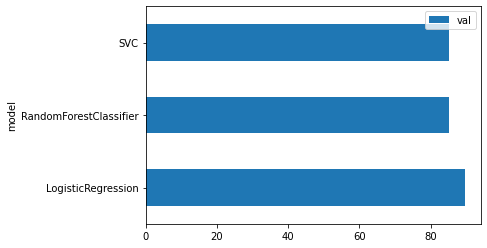

In [34]:
model_name = [type(x).__name__ for x in models]
plot_df = pd.DataFrame({'model':model_name,'val':accs}).set_index('model')
print(plot_df)
plot_df.plot.barh();

So s√°nh ƒë·ªô ch√≠nh x√°c gi·ªØa c√°c m√¥ h√¨nh v·ªõi nhau, ta th·∫•y kh√¥ng c√≥ ch√™nh l·ªách qu√° l·ªõn. 

N·∫øu x√©t kho·∫£ng c√°ch gi·ªØa m√¥ h√¨nh c√≥ ƒë·ªô ch√≠nh x√°c l·ªõn nh·∫•t v√† th·∫•p nh·∫•t th√¨ v·∫´n c√≥ s·ª± ch√™nh l·ªách ƒë√°ng xem x√©t.

M√¥ h√¨nh v·ªõi ƒë·ªô ch√≠nh x√°c cao nh·∫•t l√† : 

In [35]:
best_model = models[accs.index(max(accs))]
best_model, max(accs)

(LogisticRegression(), 89.55223880597015)

### Ma tr·∫≠n l·ªói c·ªßa c√°c m√¥ h√¨nh

M·ªôt ti√™u ch√≠ ƒë·ªÉ ƒë√°nh gi√° m√¥ h√¨nh ph√¢n l·ªõp trong nh·ªØng b√†i to√°n nh∆∞ th·∫ø n√†y l√† d√πng ma tr·∫≠n l·ªói.  

Ta s·∫Ω quan t√¢m t·ªõi √¥ (0,1) - t·ªâ l·ªá fake news nh∆∞ng b·ªã d·ª± ƒëo√°n l√† real news v√† √¥ (1,0) t·ªâ l·ªá real news b·ªã d·ª± ƒëo√°n l√† fake news.  

R√µ r√†ng t·ªâ l·ªá fake news b·ªã d·ª± ƒëo√°n l√† real news l√† t·ªâ l·ªá ƒë√°ng ƒë∆∞·ª£c quan t√¢m h∆°n b·ªüi khi th√¥ng tin gi·∫£ ƒë∆∞·ª£c cho l√† th√¥ng tin th·∫≠t th√¨ s·∫Ω ƒë∆∞·ª£c ti·∫øp nh·∫≠n v√†o g√¢y ra s·ª± nh·∫´m l·∫ßn. C√≤n khi th√¥ng tin th·∫≠t b·ªã g·∫Øn l√† th√¥ng tin gi·∫£ th√¨ ta ch·ªâ c√≥ th·ªÉ b·ªã thi·∫øu th√¥ng tin (kh√¥ng bi·∫øt c√≤n ƒë·ª° bi·∫øt bi·∫øt nh·ªØng th·ª© sai).

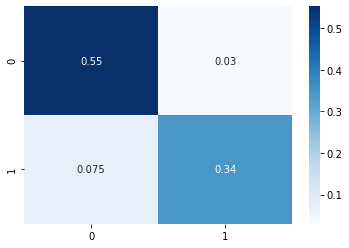

In [36]:
sns.heatmap(cm[0],annot=True,cmap='Blues');

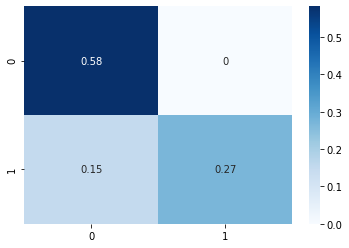

In [37]:
sns.heatmap(cm[1],annot=True,cmap='Blues');

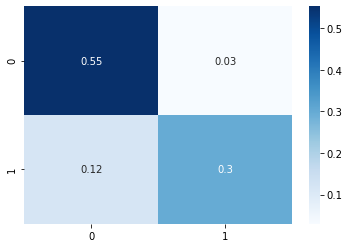

In [38]:
sns.heatmap(cm[2],annot=True,cmap='Blues');

C√≥ th·ªÉ th·∫•y m√¥ h√¨nh LogisticRegression cho ra k·∫øt qu·∫£ kh√° t·ªët khi √¥ 0,1 chi·∫øm t·ªâ l·ªá th·∫•p nh·∫•t trong ba m√¥ h√¨nh v√† ƒë·ªìng th·ªùi t·ªïng t·ªâ l·ªá l·ªói c≈©ng l√† th·∫•p nh·∫•t.

# Pipeline cho vi·ªác deploy m√¥ h√¨nh + save m√¥ h√¨nh
Ti·∫øn h√†nh x√¢y d·ª±ng pipe cho ph·∫ßn deploy.

Ti·∫øn h√†nh hu·∫•n luy·ªán c√°c m√¥ h√¨nh ƒë√£ ch·ªçn tr√™n t·∫≠p d·ªØ li·ªáu ƒë·∫ßy ƒë·ªß (ch·ª© kh√¥ng chia train v√† validation nh∆∞ tr√™n) :

In [39]:
models_name = ['LogisticRegression','RandomForestClassifier', 'SVC']

for i in range(len(pipelines)):
    
    pipelines[i].fit(data['joined_clean_text'],data['label'])

    #save model
    with open('models_saved/' + models_name[i] + '.pkl','wb') as f:
        pickle.dump(pipelines[i],f)

Test th·ª≠ c√°c pipeline khi ch·∫°y tr√™n ch√≠nh t·∫≠p hu·∫•n luy·ªán (d√π ƒëi·ªÅu n√†y kh√° v√¥ nghƒ©a, nh∆∞ng c·ª© ch·∫°y th·ª≠)

In [40]:
for i in range(len(pipelines)):
    y_pred = pipelines[i].predict(fullPreprocess(data['text']))
    print(accuracy_score(y_pred,data['label']))

1.0
1.0
1.0


# Th·ª≠ v·ªõi m·ªôt ƒëo·∫°n tin t·ª©c tr∆∞·ªõc khi deploy
Test m·ªôt b√†i b√°o l√° c·∫£i c√≥ n·ªôi dung gi·∫≠t g√¢n "nam thanh ni√™n ƒëi·ªÉn trai b·ªóng tr·ªü th√†nh **ng∆∞·ªùi r·∫Øn** üò±. V·ªõi k·∫øt qu·∫£ qu√° r√µ r√†ng nh∆∞ v·∫≠y th√¨ c·∫£ ba m√¥ h√¨nh ƒë·ªÅu d·ª± ƒëo√°n l√† fake news theo k·ª≥ v·ªçng.

In [41]:
text_test = "Ch·ªâ m·ªõi 3 th√°ng ph√°t b·ªánh, nam thanh ni√™n ƒëi·ªÉn trai b·ªóng tr·ªü th√†nh ‚Äúng∆∞·ªùi r·∫Øn‚Äù v·ªõi l√†n da n·ª©t to√°t ƒëen x√¨. Ho√†n c·∫£nh ngh√®o t√∫ng l·∫°i m·∫∑c c·∫£m v√¨ b·ªánh t·∫≠t, ch√†ng trai 24 tu·ªïi kh√¥ng ch·ªãu ƒÉn u·ªëng n√™n th√¢n h√¨nh c√†ng g·∫ßy c√≤m ƒë√°ng s·ª£.\n \n Sinh ra trong ho√†n c·∫£nh ngh√®o kh·ªï, m·∫π b·ªánh t·∫≠t n·∫±m vi·ªán nhi·ªÅu nƒÉm tr·ªùi, ch√†ng trai 24 tu·ªïi v·ªõi bao ho√†i b√£o l·∫≠p nghi·ªáp ƒë·ªÉ c√≥ kh·∫£ nƒÉng ch·ªØa b·ªánh cho m·∫π. V·∫≠y m√†, t·∫•t c·∫£ ƒë√£ s·ª•p ƒë·ªï khi S√°ng b·∫•t ng·ªù b·ªã cƒÉn b·ªánh k√¨ l·∫°, qu√°i √°c.\n \n Ho√†n c·∫£nh ƒë√°ng th∆∞∆°ng c·ªßa ch√†ng trai 24 tu·ªïi m·∫Øc b·ªánh ‚Äúng∆∞·ªùi r·∫Øn‚Äù ·ªü ·∫•p Vinh Thanh, th·ªã tr·∫•n Ng√£i Giao, huy·ªán Ch√¢u ƒê·ª©c, B√† R·ªãa V≈©ng T√†u khi·∫øn nhi·ªÅu ng∆∞·ªùi x√≥t xa.\n \n T·ª´ ch√†ng trai kh·ªèe m·∫°nh ho·∫°t b√°t.\n \n M·ªõi 3 th√°ng, S√°ng ƒë√£ ·ªëm y·∫øu, da d·∫ª n·ª©t to√°t nh∆∞ da r·∫Øn.\n \n C√°ch ƒë√¢y 3 th√°ng, S√°ng v·∫´n l√† m·ªôt thanh ni√™n ƒëi·ªÉn trai, kh·ªèe m·∫°nh. Th·∫ø nh∆∞ng, S√°ng b·∫•t ng·ªù ph√°t hi·ªán l√† da tr·ªü n√™n xanh xao l·∫° th∆∞·ªùng. V·ªën t∆∞·ªüng m√¨nh m·∫Øc b·ªánh thi·∫øu m√°u th√¥ng th∆∞·ªùng n√™n ch·ªß quan, kh√¥ng ng·ªù d·∫ßn d·∫ßn c·∫£ c∆° th·ªÉ d·∫ßn n·ª©t to√°c, ƒëen x√¨ nh∆∞ da r·∫Øn.\n \n C≈©ng v√¨ ho√†n c·∫£nh kh√≥ khƒÉn, S√°ng ch·ªâ n·∫±m vi·ªán v√†i ng√†y r·ªìi ·ªü nh√†. M·∫∑c c·∫£m b·ªánh t·∫≠t khi·∫øn ch√†ng trai 24 tu·ªïi ho·∫°t b√°t ng√†y n√†o kh√¥ng d√°m ti·∫øp x√∫c v·ªõi ng∆∞·ªùi l·∫°, c≈©ng kh√¥ng ch·ªãu ƒÉn u·ªëng n√™n c∆° th·ªÉ ng√†y c√†ng g·∫ßy c√≤m. X√≥t xa h∆°n, ch√†ng trai s·ª£ cƒÉn b·ªánh c·ªßa m√¨nh l√†m kh·ªï gia ƒë√¨nh n√™n ƒë√£ bu√¥ng tay, kh√¥ng c√≤n √Ω ch√≠ ch·ªØa b·ªánh.\n \n \n ‚Äì\n \n Gia c·∫£nh qu√° kh√≥ khƒÉn n√™n ch√†ng trai 24 tu·ªïi bu√¥ng xu√¥i, kh√¥ng mu·ªën ti·∫øp t·ª•c ch·ªØa b·ªánh.\n \n Bi·∫øt ƒë∆∞·ª£c s·ªë ph·∫≠n ƒë√°ng th∆∞∆°ng c·ªßa S√°ng, nhi·ªÅu nh√† h·∫£o t√¢m ƒë√£ k√™u g·ªçi gi√∫p ƒë·ª° v√† ƒë·ªông vi√™n em v∆∞·ª£t qua cƒÉn b·ªánh hi·ªÉm ngh√®o.\n \n ·∫¢nh: FB\n \n Nghi √Çn (T·ªïng H·ª£p)\n \n http://vi.blogtamsu.video/thanh-nien-24-bong-hoa-nguoi-ran-sau-1-dem-da-de-nut-toac-den-xi-ai-nhin-cung-hai.html"
print("N·ªôi dung b√†i b√°o :")
print(text_test[0:200]+"...")
print("K·∫øt qu·∫£ 3 m√¥ h√¨nh d·ª± ƒëo√°n : ")
for pipeline in pipelines:
    print(pipeline.predict(fullPreprocess(pd.Series([text_test]))))

N·ªôi dung b√†i b√°o :
Ch·ªâ m·ªõi 3 th√°ng ph√°t b·ªánh, nam thanh ni√™n ƒëi·ªÉn trai b·ªóng tr·ªü th√†nh ‚Äúng∆∞·ªùi r·∫Øn‚Äù v·ªõi l√†n da n·ª©t to√°t ƒëen x√¨. Ho√†n c·∫£nh ngh√®o t√∫ng l·∫°i m·∫∑c c·∫£m v√¨ b·ªánh t·∫≠t, ch√†ng trai 24 tu·ªïi kh√¥ng ch·ªãu ƒÉn u·ªëng n√™n th√¢n ...
K·∫øt qu·∫£ 3 m√¥ h√¨nh d·ª± ƒëo√°n : 
[1]
[1]
[1]


# Bonus point

### Ti·ªÅn x·ª≠ l√Ω

In [42]:
Countfit=CountVectorizer().fit(X_train)
X_train1=Countfit.transform(X_train)
X_train1 = X_train1.toarray()
X_val1=Countfit.transform(X_val)
X_val1 = X_val1.toarray()

#### Kh·ªüi t·∫°o model

In [43]:
model=tf.keras.models.Sequential()

2022-01-09 13:40:25.007444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 13:40:25.007895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 13:40:25.007947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-09 13:40:25.007979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-09 13:40:25.008016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

#### Th√™m 4 l·ªõp hidden v·ªõi activation l√† "relu"

In [44]:
model.add(tf.keras.layers.Dense(10,input_shape=(X_train1.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dense(8,activation="relu"))
model.add(tf.keras.layers.Dense(6,activation="relu"))
model.add(tf.keras.layers.Dense(8,activation="relu"))

#### Th√™m l·ªõp output v·ªõi 1 unit c√≥ h√†m activation l√† "sigmoid" (sigmoid tr·∫£ v·ªÅ x√°c su·∫•t t·ª´ 0->1)

In [45]:
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

#### Bi√™n d·ªãch m√¥ h√¨nh

In [46]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#### Fit model (30 l·∫ßn)

In [47]:
model.fit(X_train1, y_train, epochs=40)

Epoch 1/40
5/5 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5000
Epoch 2/40
5/5 [==============================] - 0s 1ms/step - loss: 0.6510 - accuracy: 0.6667
Epoch 3/40
5/5 [==============================] - 0s 1ms/step - loss: 0.6087 - accuracy: 0.6859
Epoch 4/40
5/5 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.7372
Epoch 5/40
5/5 [==============================] - 0s 1ms/step - loss: 0.5012 - accuracy: 0.7628
Epoch 6/40
5/5 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7436
Epoch 7/40
5/5 [==============================] - 0s 1ms/step - loss: 0.4087 - accuracy: 0.8718
Epoch 8/40
5/5 [==============================] - 0s 1ms/step - loss: 0.3761 - accuracy: 0.8910
Epoch 9/40
5/5 [==============================] - 0s 1ms/step - loss: 0.3491 - accuracy: 0.9231
Epoch 10/40
5/5 [==============================] - 0s 1ms/step - loss: 0.3226 - accuracy: 0.9679
Epoch 11/40
5/5 [======================

#### ƒê√°nh gi√° m√¥ h√¨nh

In [48]:
model.evaluate(X_val1,y_val,verbose=0)

[0.35917341709136963, 0.8358209133148193]

#### D·ª± ƒëo√°n 

In [49]:
y_val_predict=model.predict(X_val1)
y_val_predict=y_val_predict[:,0]
y_val_predict=np.round(y_val_predict).astype('int')
y_val_predict

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1])

#### ƒê·ªô ch√≠nh x√°c

In [50]:
accuracy_score(y_val,y_val_predict)

0.835820895522388

## Link deploy
Demo cho ch∆∞∆°ng tr√¨nh: [Link](https://share.streamlit.io/lokito01/demo-fakenewsdetection-ml/app.py)

## Ngu·ªìn tham kh·∫£o

https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

https://maelfabien.github.io/machinelearning/NLP_1/#i-what-is-preprocessing

https://github.com/SushwanthReddy/Fake-News-Detection-using-Machine-Learning/blob/master/FakeNewsDetection.ipynb?fbclid=IwAR1G2t9F6YJ3Wu6WPIpOX6GKV8oMF7PXRiUNqLHZzjhOP-uHw_wKORCmedg

https://www.kaggle.com/rodolfoluna/fake-news-detector?fbclid=IwAR31X9TZK68xc-G0nndQ8eF0YJXd0oRa-tj1levZvflUhm5V4cllmMBErmA

<hr>
